In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import glob
import fnmatch 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from collections import Counter
import concurrent.futures
from functools import partial
from PIL import Image
from os import listdir
import pandas as pd
import numpy as np

!pip install kaggle


/home/rphorsterphages_gmail_com/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define custom dataset
class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

The below section has three code blocks to 1) download the dataset and extracts labels. 2) download the dataset and load the extracted labels and 3) just extract the labels. This is so you don't have to re-download or extract labels.

In [ ]:

# Set the paths for the Kaggle data
dataset_zip_path = 'breast-histopathology-images.zip'
dataset_extracted_path = 'dataset_path'

# Check if the dataset directory already exists
if not os.path.exists(dataset_extracted_path):
    # Check if the dataset zip file already exists
    if not os.path.exists(dataset_zip_path):
        # Move the Kaggle API file
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        # Download the Kaggle dataset
        !kaggle datasets download -d paultimothymooney/breast-histopathology-images
        # Extract the dataset
        !unzip -q breast-histopathology-images.zip -d $dataset_extracted_path
    else:
        print("Dataset zip file already exists.")
else:
    print("Dataset directory already exists.")

# Set the paths to the downloaded dataset
image_paths = glob.glob('dataset_path/*/*/*.png', recursive=True)
print(len(image_paths))
print(image_paths[0])

# get labels
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(image_paths, patternZero)
classOne = fnmatch.filter(image_paths, patternOne)


labels = []

def process_image(img, classZero, classOne):
    if img in classZero:
        return 0
    elif img in classOne:
        return 1

def process_images_parallel(image_paths, classZero, classOne):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        process_func = partial(process_image, classZero=classZero, classOne=classOne)
        labels = list(tqdm(executor.map(process_func, image_paths), total=len(image_paths)))
    return labels

labels = process_images_parallel(image_paths, classZero, classOne)


100% 3.10G/3.10G [02:27<00:00, 24.1MB/s]
100% 3.10G/3.10G [02:27<00:00, 22.6MB/s]
555048
dataset_path/13401/1/13401_idx5_x1701_y801_class1.png


100%|██████████| 555048/555048 [34:05<00:00, 271.35it/s]


In [11]:
# Set the paths for the Kaggle data
dataset_zip_path = 'breast-histopathology-images.zip'
dataset_extracted_path = 'dataset_path'

# Check if the dataset directory already exists
if not os.path.exists(dataset_extracted_path):
    # Check if the dataset zip file already exists
    if not os.path.exists(dataset_zip_path):
        # Move the Kaggle API file
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        # Download the Kaggle dataset
        !kaggle datasets download -d paultimothymooney/breast-histopathology-images
        # Extract the dataset
        !unzip -q breast-histopathology-images.zip -d $dataset_extracted_path
    else:
        print("Dataset zip file already exists.")
else:
    print("Dataset directory already exists.")

# Set the paths to the downloaded dataset
image_paths = glob.glob('dataset_path/*/*/*.png', recursive=True)
print(len(image_paths))
print(image_paths[0])
labels = []
with open('labels.txt', 'r') as file:
    for line in file:
        label = int(line.strip())
        labels.append(label)

100%|█████████████████████████████████████▉| 3.09G/3.10G [00:14<00:00, 78.6MB/s]
100%|███████████████████████████████████████| 3.10G/3.10G [00:14<00:00, 224MB/s]
555048
dataset_path/12818/0/12818_idx5_x2551_y2051_class0.png


In [3]:
# Set the paths to the downloaded dataset
dataset_extracted_path = 'dataset_path'
image_paths = glob.glob('dataset_path/*/*/*.png', recursive=True)
print(len(image_paths))
print(image_paths[0])
labels = []
with open('labels.txt', 'r') as file:
    for line in file:
        label = int(line.strip())
        labels.append(label)
print(len(labels))

277524
dataset_path/12818/0/12818_idx5_x2551_y2051_class0.png
277524


The block below uses the images with no patient context to grab positive and negative samples for invasive ductal carcinoma. What you will see is that it is very hard to tell the difference and may require patient context, also we might have leakage into test set and ideally we want to test on a different distributions to truely validate the model. https://datascience.stanford.edu/news/splitting-data-randomly-can-ruin-your-model

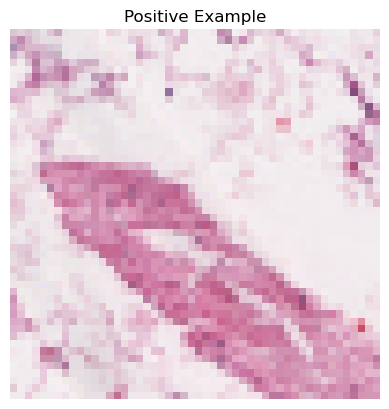

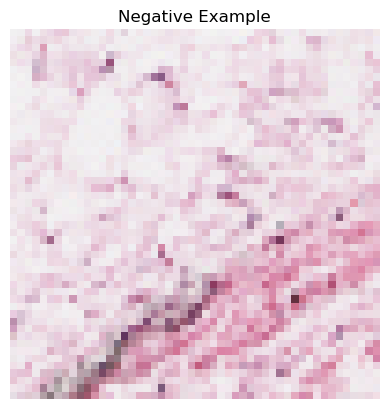

In [4]:
# Assuming 'image_paths' contains the paths to the images
# Assuming 'labels' contains the corresponding labels (0 for negative, 1 for positive)

# Find the indices of positive and negative examples
positive_indices = [i for i, label in enumerate(labels) if label == 1]
negative_indices = [i for i, label in enumerate(labels) if label == 0]

# Display a positive image
positive_image_path = image_paths[positive_indices[1]]
positive_image = mpimg.imread(positive_image_path)
plt.imshow(positive_image)
plt.title("Positive Example")
plt.axis('off')
plt.show()

# Display a negative image
negative_image_path = image_paths[negative_indices[200]]
negative_image = mpimg.imread(negative_image_path)
plt.imshow(negative_image)
plt.title("Negative Example")
plt.axis('off')
plt.show()

To provide pateint context I will create a dataframe with patient ids, image paths and target/labels that I can use to split data by patient.

In [5]:
dataset_patient_path = "dataset_path/"
folder = os.listdir(dataset_patient_path)

num_images = len(image_paths)
data = pd.DataFrame(index=range(num_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    if patient_id == "IDC_regular_ps50_idx5":
        continue  # Skip the IDC_regular_ps50_idx5 folder
        
    patient_path = os.path.join(dataset_patient_path, patient_id)
    
    for c in [0, 1]:
        class_path = os.path.join(patient_path, str(c))
        subfiles = os.listdir(class_path)
        
        data.loc[k:k+len(subfiles)-1, "path"] = [os.path.join(class_path, subfile) for subfile in subfiles]
        data.loc[k:k+len(subfiles)-1, "target"] = c
        data.loc[k:k+len(subfiles)-1, "patient_id"] = patient_id
        
        k += len(subfiles)

data.reset_index(drop=True, inplace=True)
data.head()

,patient_id,path,target
0,12818,dataset_path/12818/0/12818_idx5_x2551_y2051_cl...,0
1,12818,dataset_path/12818/0/12818_idx5_x851_y1451_cla...,0
2,12818,dataset_path/12818/0/12818_idx5_x1251_y901_cla...,0
3,12818,dataset_path/12818/0/12818_idx5_x3651_y1651_cl...,0
4,12818,dataset_path/12818/0/12818_idx5_x1651_y1951_cl...,0


To prevent overfitting I flipped the photos randomly and I normalized the data using imagenet to train relative to the distribution of the pretrained model's.

In [6]:
##########################Training with patient context:

patients = data.patient_id.unique()


train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=42)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=42)


train_df = data[data.patient_id.isin(train_ids)]
dev_df = data[data.patient_id.isin(dev_ids)]
test_df = data[data.patient_id.isin(test_ids)]

train_image_paths = list(train_df['path'])
train_labels = list(train_df['target'])
dev_image_paths = list(dev_df['path'])
dev_labels = list(dev_df['target'])
test_image_paths = list(test_df['path'])
test_labels = list(test_df['target'])

transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

class_freq = Counter(train_df['target'])
total_samples = len(train_df['target'])
class_weights = [total_samples / (class_freq[i] * len(class_freq)) for i in range(len(class_freq))]
class_weights = torch.tensor(class_weights, dtype=torch.double)
sample_weights = [class_weights[label] for label in train_df['target']]
sampler = WeightedRandomSampler(sample_weights, len(train_labels), replacement=True)




train_dataset = BreastCancerDataset(train_image_paths, train_labels, transform=transform)
dev_dataset = BreastCancerDataset(dev_image_paths, dev_labels, transform=transform)
test_dataset = BreastCancerDataset(test_image_paths, test_labels, transform=transform)


batch_size = 32
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=32 ,pin_memory=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32 ,pin_memory=True)#########################

I am using Swin Transformer, the model is likely overkill, however I want to play with the latest model architecture for computer vision tasks and compare to the model orignally used on this dataset. SwinTransformer:https://openaccess.thecvf.com/content/CVPR2022/papers/Liu_Swin_Transformer_V2_Scaling_Up_Capacity_and_Resolution_CVPR_2022_paper.pdf 

In [7]:
# Load the pre-trained model
model = models.swin_v2_t(weights='DEFAULT')
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one
num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),  # BatchNorm layer added
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),  # BatchNorm layer added
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

# Define the loss function and optimizer (uses frequency weights)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


/tmp/ipykernel_27882/2846083555.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


In [8]:
# Train the model
num_epochs = 30
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.train()

# Lists to store training and test loss
train_losses = []
train_accuracies = []

for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    epoch_accuracy = 100 * correct / total
    train_accuracies.append(epoch_accuracy)
# Calculate final accuracy
final_accuracy = train_accuracies[-1]
print(f"Final Accuracy: {final_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'breast_cancer_model_swin.pth')

  3%|████▏                                                                                                                        | 1/30 [16:26<7:56:37, 986.14s/it]

Epoch [1/30], Loss: 0.4334


  7%|████████▎                                                                                                                    | 2/30 [32:56<7:41:22, 988.68s/it]

Epoch [2/30], Loss: 0.3981


 10%|████████████▍                                                                                                               | 3/30 [49:56<7:31:25, 1003.16s/it]

Epoch [3/30], Loss: 0.3915


 13%|████████████████▍                                                                                                          | 4/30 [1:06:17<7:10:52, 994.32s/it]

Epoch [4/30], Loss: 0.3850


 17%|████████████████████▌                                                                                                      | 5/30 [1:22:20<6:49:33, 982.94s/it]

Epoch [5/30], Loss: 0.3820


 20%|████████████████████████▌                                                                                                  | 6/30 [1:38:34<6:31:56, 979.85s/it]

Epoch [6/30], Loss: 0.3803


 23%|████████████████████████████▋                                                                                              | 7/30 [1:54:45<6:14:33, 977.11s/it]

Epoch [7/30], Loss: 0.3766


 27%|████████████████████████████████▊                                                                                          | 8/30 [2:10:48<5:56:38, 972.67s/it]

Epoch [8/30], Loss: 0.3744


 30%|████████████████████████████████████▉                                                                                      | 9/30 [2:26:55<5:39:45, 970.76s/it]

Epoch [9/30], Loss: 0.3729


 33%|████████████████████████████████████████▋                                                                                 | 10/30 [2:43:05<5:23:31, 970.60s/it]

Epoch [10/30], Loss: 0.3710


 37%|████████████████████████████████████████████▋                                                                             | 11/30 [2:59:19<5:07:37, 971.44s/it]

Epoch [11/30], Loss: 0.3695


 40%|████████████████████████████████████████████████▊                                                                         | 12/30 [3:15:08<4:49:24, 964.68s/it]

Epoch [12/30], Loss: 0.3693


 43%|████████████████████████████████████████████████████▊                                                                     | 13/30 [3:30:48<4:31:14, 957.35s/it]

Epoch [13/30], Loss: 0.3681


 47%|████████████████████████████████████████████████████████▉                                                                 | 14/30 [3:46:52<4:15:50, 959.40s/it]

Epoch [14/30], Loss: 0.3681


 50%|█████████████████████████████████████████████████████████████                                                             | 15/30 [4:02:25<3:57:49, 951.31s/it]

Epoch [15/30], Loss: 0.3662


 53%|█████████████████████████████████████████████████████████████████                                                         | 16/30 [4:18:38<3:43:30, 957.89s/it]

Epoch [16/30], Loss: 0.3664


 57%|█████████████████████████████████████████████████████████████████████▏                                                    | 17/30 [4:34:41<3:27:49, 959.22s/it]

Epoch [17/30], Loss: 0.3649


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 18/30 [4:50:59<3:13:00, 965.07s/it]

Epoch [18/30], Loss: 0.3657


 63%|█████████████████████████████████████████████████████████████████████████████▎                                            | 19/30 [5:07:02<2:56:48, 964.40s/it]

Epoch [19/30], Loss: 0.3655


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 20/30 [5:23:01<2:40:26, 962.70s/it]

Epoch [20/30], Loss: 0.3627


 70%|█████████████████████████████████████████████████████████████████████████████████████▍                                    | 21/30 [5:39:27<2:25:28, 969.84s/it]

Epoch [21/30], Loss: 0.3616


 73%|█████████████████████████████████████████████████████████████████████████████████████████▍                                | 22/30 [5:55:24<2:08:46, 965.77s/it]

Epoch [22/30], Loss: 0.3637


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▌                            | 23/30 [6:11:28<1:52:38, 965.51s/it]

Epoch [23/30], Loss: 0.3633


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 24/30 [6:27:58<1:37:15, 972.64s/it]

Epoch [24/30], Loss: 0.3618


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 25/30 [6:44:47<1:21:57, 983.54s/it]

Epoch [25/30], Loss: 0.3630


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 26/30 [7:01:04<1:05:27, 981.75s/it]

Epoch [26/30], Loss: 0.3616


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 27/30 [7:17:18<48:57, 979.27s/it]

Epoch [27/30], Loss: 0.3614


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 28/30 [7:33:41<32:40, 980.34s/it]

Epoch [28/30], Loss: 0.3622


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29/30 [7:50:25<16:27, 987.58s/it]

Epoch [29/30], Loss: 0.3612


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [8:07:00<00:00, 974.03s/it]

Epoch [30/30], Loss: 0.3608
Final Accuracy: 84.48%


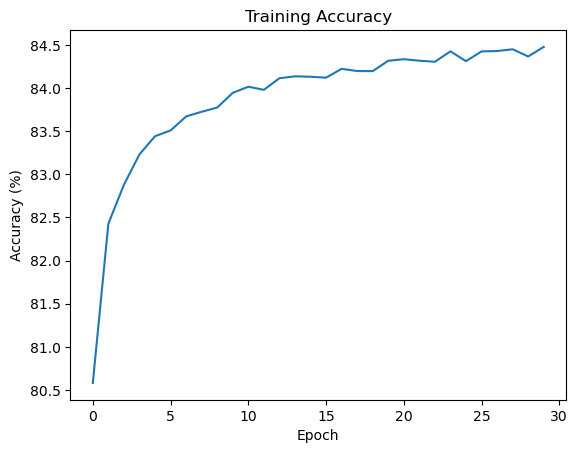

In [9]:
plt.plot(range(num_epochs), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.savefig('Acurve_BCMs.pdf')
plt.show()

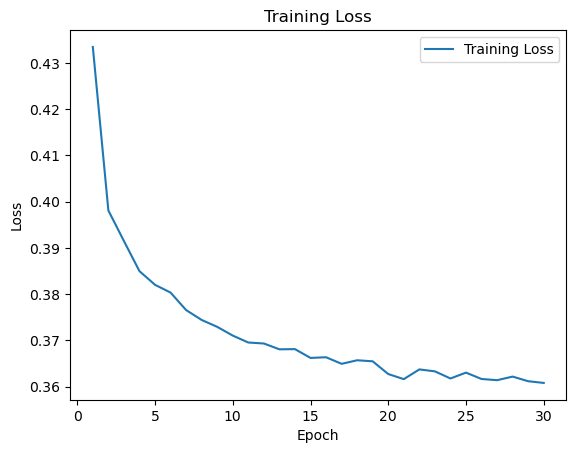

In [10]:
# Plot training over time 
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('Lcurve_BCM.pdf')
plt.show()

Dev Accuracy: 83.33%
Dev Loss: 0.3770
F1 Score: 0.7318


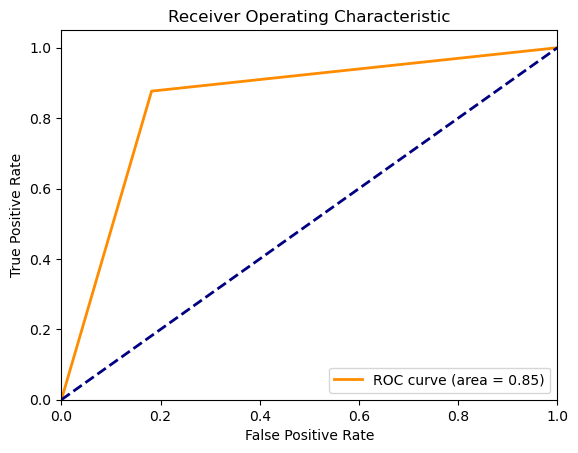

In [13]:
#Evaluate the model
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=32 ,pin_memory=True)
model.eval()
correct_predictions = 0
total_predictions = 0
dev_losses = []
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in dev_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Calculate loss
        loss = criterion(outputs, labels)
        dev_losses.append(loss.item())

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    dev_accuracy = 100 * correct_predictions / total_predictions
    dev_loss = sum(dev_losses) / len(dev_losses)
    print(f"Dev Accuracy: {dev_accuracy:.2f}%")
    print(f"Dev Loss: {dev_loss:.4f}")
    # Calculate F1 score
    f1 = f1_score(true_labels, predictions)
    print(f"F1 Score: {f1:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_BCMS_dev.pdf')
plt.show()

Test Accuracy: 82.32%
Test Loss: 0.4011
F1 Score: 0.7534
Confusion Matrix:
[[22144  5429]
 [ 1652 10816]]
Balanced Accuracy: 0.8353


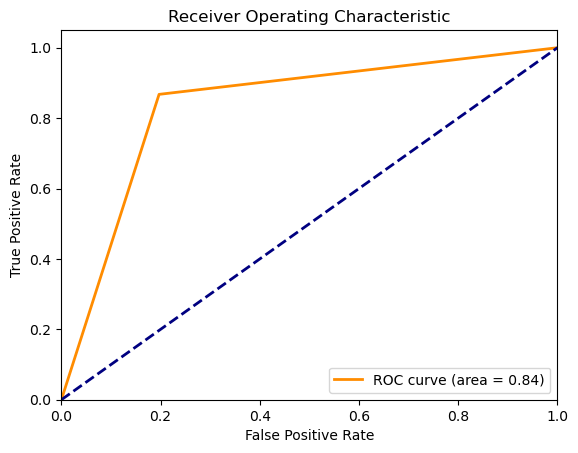

In [14]:
# Evaluate the model
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=32 ,pin_memory=True)
model.eval()
correct_predictions = 0
total_predictions = 0
test_losses = []
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Calculate loss
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_predictions / total_predictions
    test_loss = sum(test_losses) / len(test_losses)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Calculate F1 score
    f1 = f1_score(true_labels, predictions)
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(true_labels, predictions)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_BCMS_test.pdf')
plt.show()

Automatic detection of invasive ductal carcinoma in whole slide images with convolutional neural networks: https://www.spiedigitallibrary.org/conference-proceedings-of-spie/9041/904103/Automatic-detection-of-invasive-ductal-carcinoma-in-whole-slide-images/10.1117/12.2043872.short

In this paper they used a 3-layer conv.net and achieved in terms of F1 score and balanced accuracy of (71.80%, 84.23%). Our implementation of the Swin Transformer model achieved an F1 score and balanced accuracy of (75.34%, 83.53%) on the test set. 